In [1]:
import astropy.coordinates as ac
import astropy.units as au
import numpy as np
import pylab as plt

from dsa2000_cal.common.serialise_utils import SerialisableBaseModel


def get_num_sky_pointings(pointing_separation: au.Quantity) -> int:
    if not pointing_separation.unit.is_equivalent('deg'):
        raise ValueError("Pointing separation must be in degrees")
    # Sky area of a pointing
    pointing_area = 2. * np.pi * (1. - np.cos(pointing_separation.to('rad')))
    all_sky_area = 4. * np.pi
    # Round to closest integer
    pointings_per_sky = int(np.round(all_sky_area / pointing_area))
    return pointings_per_sky

/dsa/code/package/src/dsa2000_cal/common/mixed_precision_utils.py:10: UserWarning: JAX x64 is not enabled. Setting it now, but check for errors.
  warnings.warn("JAX x64 is not enabled. Setting it now, but check for errors.")


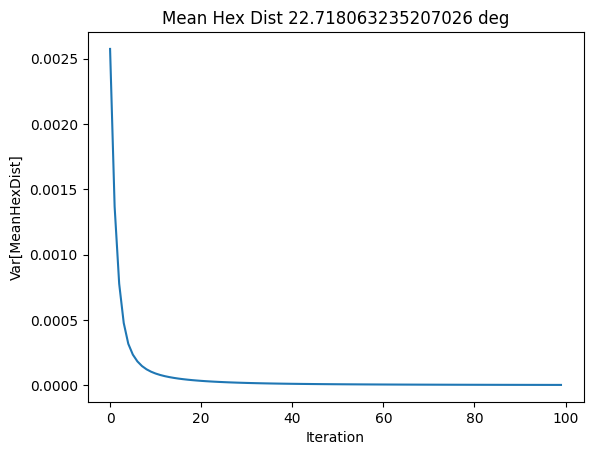

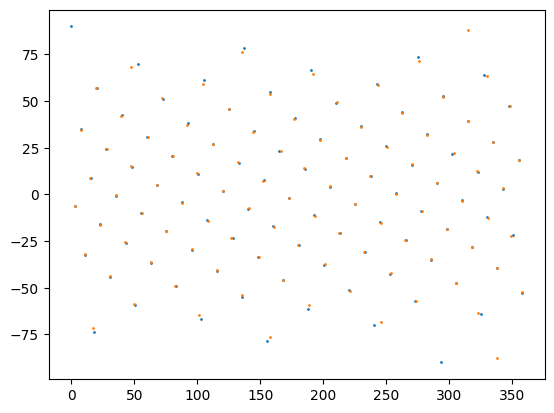

100 412.52961249419275 deg2


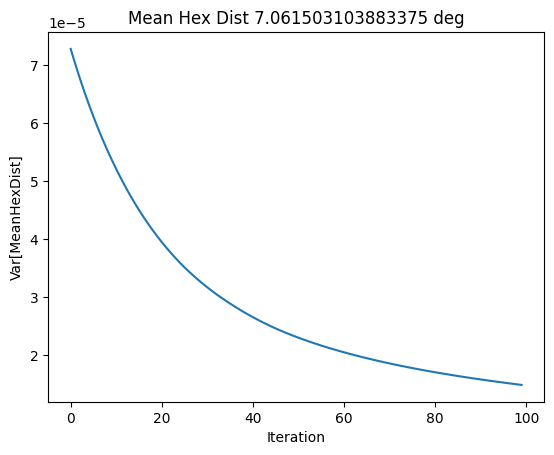

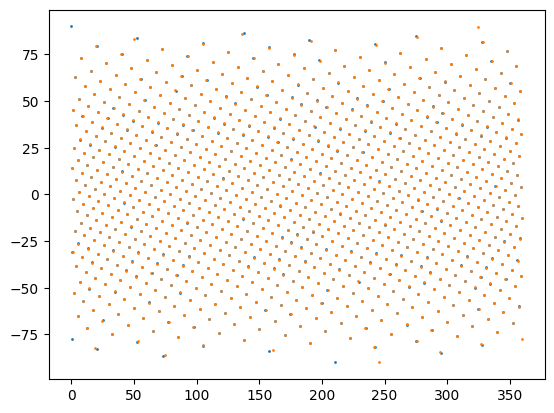

1000 41.25296124941928 deg2


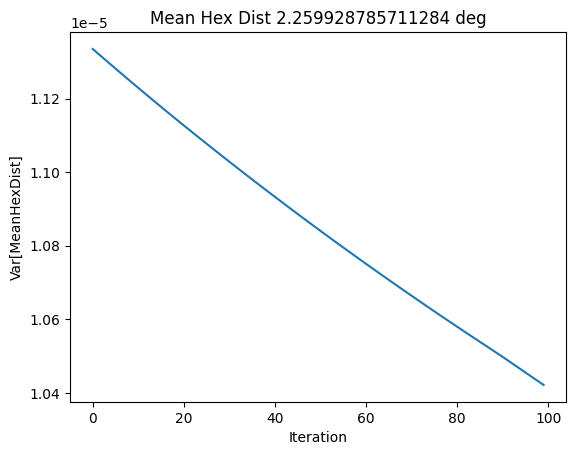

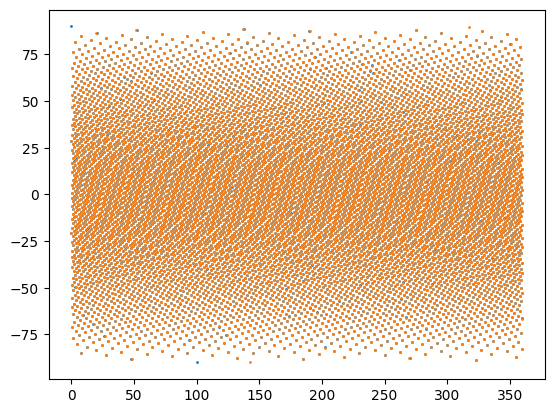

10000 4.1252961249419275 deg2


In [2]:


import jax
import jax.numpy as jnp
from scipy.spatial import KDTree


def fibonacci_celestial_sphere(n: int) -> ac.ICRS:
    """
    Generates 'n' points on the surface of a sphere using the Fibonacci sphere algorithm.

    Args:
        n (int): Number of points to generate.

    Returns:
        lon (jnp.ndarray): Array of longitudes in radians.
        lat (jnp.ndarray): Array of latitudes in radians.
    """
    # Golden angle in radians
    golden_angle = np.pi * (3.0 - np.sqrt(5.0))  # Approximately 2.39996 radians

    # Indices from 0 to n-1
    indices = np.arange(n)

    # Compute y coordinates (latitude component)
    y = 1 - (2 * indices) / (n - 1)  # y ranges from 1 to -1

    # Compute latitude in radians
    lat = np.arcsin(y)

    # Compute longitude in radians
    theta = golden_angle * indices
    lon = theta % (2 * np.pi)  # Ensure longitude is within [0, 2π)

    return ac.ICRS(lon * au.rad, lat * au.rad)


def to_cartesian(pointings: ac.ICRS) -> np.ndarray:
    x = np.cos(pointings.ra) * np.cos(pointings.dec)
    y = np.sin(pointings.ra) * np.cos(pointings.dec)
    z = np.sin(pointings.dec)
    # Stack the coordinates
    coords = jnp.asarray(np.stack([x, y, z], axis=-1))  # [n, 3]
    return coords


def to_spherical(coords: np.ndarray) -> ac.ICRS:
    ra = np.arctan2(coords[:, 1], coords[:, 0]) * au.rad
    dec = np.arcsin(coords[:, 2]) * au.rad
    return ac.ICRS(ra, dec)


def refine_points(pointings: ac.ICRS, n: int = 100, k: int = 6, lr: float = 1., dist_type: str = 'dot') -> ac.ICRS:
    # Use force relaxation to uniformly distribute, using KDTree
    # Compute the cartesian coordinates from ra/dec
    coords = jnp.asarray(to_cartesian(pointings))

    @jax.jit
    def update_step(coords, idx, lr):
        def loss(coords):
            dist = jnp.zeros(np.shape(coords)[0:1], coords.dtype)
            for i in range(k):
                if dist_type == 'dot':
                    dist += jnp.arccos(jnp.sum(coords * coords[idx[:, i]], axis=-1))
                elif dist_type == 'euclidean':
                    dist += jnp.linalg.norm(coords - coords[idx[:, i]], axis=-1)
                else:
                    raise ValueError(f"Invalid dist_type: {dist_type}")
            return jnp.var(dist), jnp.mean(dist) / k

        val_grad_fn = jax.value_and_grad(loss, has_aux=True)
        (val, mean_hex_dist), grad = val_grad_fn(coords)
        # update
        coords = coords - lr * grad
        # project back to sphere
        coords /= jnp.linalg.norm(coords, axis=-1, keepdims=True)
        return coords, val, mean_hex_dist

    val = np.inf
    mean_hex_dist = np.inf
    lr = jnp.asarray(lr)
    lrs = []
    vals = []
    for iteration in range(n):
        tree = KDTree(coords)
        #forces for each partical
        dist, idx = tree.query(coords, k=k + 1)
        # exclude self point
        idx = jnp.asarray(idx[:, 1:])  # [n, k]
        # dist = dist[:, 1:]  # [n, k]
        while True:
            _coords, _val, _mean_hex_dist = update_step(coords, idx, lr)
            if lr < 1e-5:
                break
            if _val > val:
                lr *= 0.5
                continue
            else:
                coords = _coords
                val = _val
                mean_hex_dist = _mean_hex_dist
                break
        vals.append(val)
        lrs.append(lr)
        if lr < 1e-5:
            break

    plt.plot(vals)
    plt.xlabel("Iteration")
    plt.ylabel("Var[MeanHexDist]")
    plt.title(f"Mean Hex Dist {(mean_hex_dist * au.rad).to('deg')}")
    plt.show()
    # Compute the new ra/dec
    return to_spherical(np.asarray(coords))


for n in [100, 1000, 10000]:
    pointings = fibonacci_celestial_sphere(n=n)
    # plt.show()

    refined_pointings = refine_points(pointings,)
    plt.scatter(pointings.ra, pointings.dec, s=1)
    plt.scatter(refined_pointings.ra, refined_pointings.dec, s=1)
    plt.show()

    mean_area = (4 * np.pi / n) * au.rad ** 2
    print(n, mean_area.to('deg^2'))

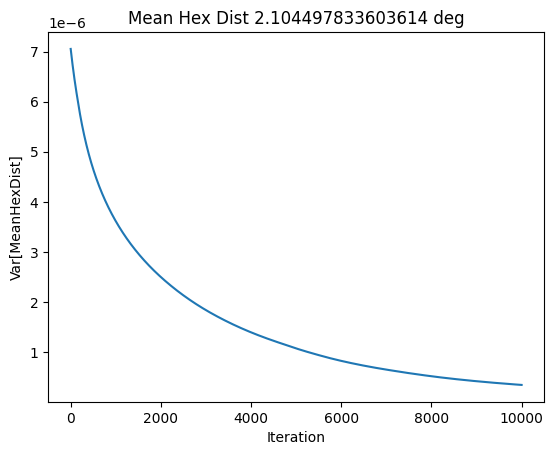

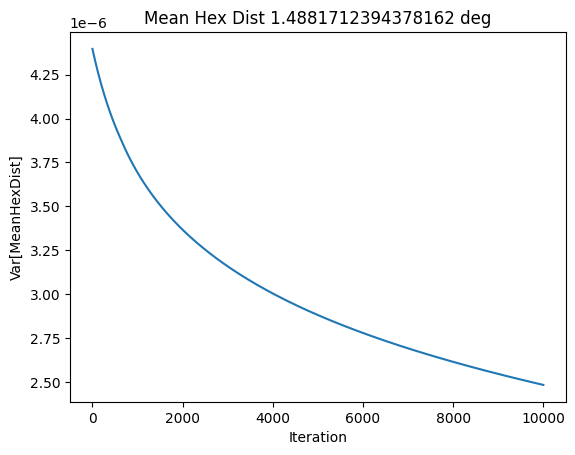

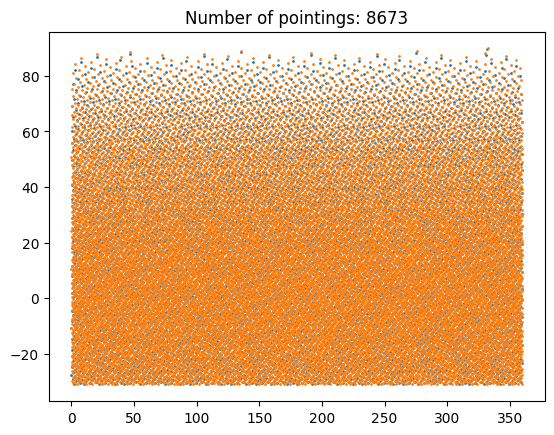

In [10]:
def build_survey_moasic_pattern(num_pointings: int | None, point_separation: au.Quantity | None, lower_dec: au.Quantity,
                                upper_dec: au.Quantity) -> ac.ICRS:
    """
    Builds a survey mosaic pattern.

    Args:
        point_separation: the separation between pointing centres

    Returns:
        the mosaic pattern
    """
    # Get the number of pointings
    if num_pointings is None:
        num_pointings = get_num_sky_pointings(point_separation)
    # Generate the pointings
    pointings = fibonacci_celestial_sphere(n=num_pointings)
    pointings = refine_points(pointings, n=10000)
    if not lower_dec.unit.is_equivalent('deg'):
        raise ValueError("Lower declination must be in degrees")
    if not upper_dec.unit.is_equivalent('deg'):
        raise ValueError("Upper declination must be in degrees")
    # Filter the pointings
    pointings = pointings[pointings.dec >= lower_dec]
    pointings = pointings[pointings.dec <= upper_dec]
    return pointings


pointings = build_survey_moasic_pattern(num_pointings=int(8600*1.33), point_separation=None, lower_dec=-31 * au.deg,
                                        upper_dec=90 * au.deg)

cal_pointings = build_survey_moasic_pattern(num_pointings=2*int(8600*1.33), point_separation=None, lower_dec=-31 * au.deg,
                                        upper_dec=90 * au.deg)
plt.scatter(pointings.ra, pointings.dec, s=1)
plt.scatter(cal_pointings.ra, cal_pointings.dec, s=1)
plt.title(f"Number of pointings: {len(pointings)}")
plt.show()

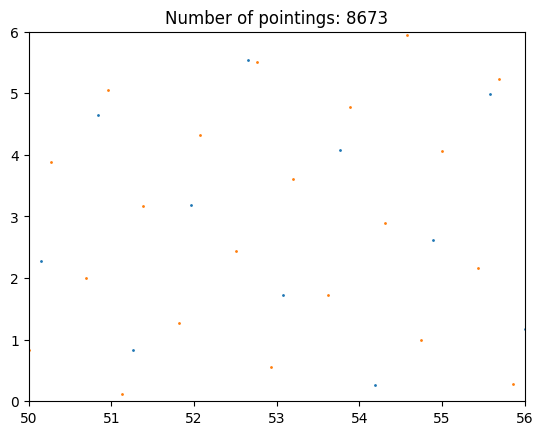

In [11]:
plt.scatter(pointings.ra, pointings.dec, s=1)
plt.scatter(cal_pointings.ra, cal_pointings.dec, s=1)
plt.title(f"Number of pointings: {len(pointings)}")
plt.xlim(50, 56)
plt.ylim(0,6)
plt.show()

In [12]:
# store in wsclean format

with open('mock_calibrators.txt', 'w') as f:
    f.write("Format = Name, Type, Ra, Dec, I, SpectralIndex, LogarithmicSI, ReferenceFrequency='1350e6', MajorAxis, MinorAxis, Orientation\n")
    # s0c0,POINT,-00:37:22.645,58.30.45.773,0.0155566877299659,[-0.0165136382322324,0.104932421771313,0.104196786226242,-0.751510783409754],false,57322692.8710938,,,

    for i, pointing in enumerate(cal_pointings):
        f.write(
            f"s{i}c0,POINT,{pointing.ra.to_string(precision=6, sep=':', unit=au.hourangle, alwayssign=True, pad=True)},{pointing.dec.to_string(precision=5, sep='.', unit=au.deg, alwayssign=True, pad=True)},1,[-0.7],true,1350e6,,,\n"
        )

In [6]:
def compute_beam_power(dist, fov_fwhm):
    # beam_power(fov_fwhm/2) = exp(-0.5 * (fov_fwhm/2)^2 / k^2) = 1/2 ==> -8 * log(1/2) = fov_fwhm^2 / k^2 ==> k = fov_fwhm / sqrt(4 * log(4))
    k = fov_fwhm / (2 * np.sqrt(np.log(4)))
    dist /= k
    return np.exp(-0.5 * dist ** 2)


def evaluate_global_sensitivity_pattern(pointings: ac.ICRS, eval_pointings: ac.ICRS, fov_fwhm: au.Quantity,
                                        k: int = 19, flux_cut: float = 0.17):
    # convert to cartesian
    coords = to_cartesian(pointings)
    eval_coords = to_cartesian(eval_pointings)
    # get the closest eval points to each point
    tree = KDTree(coords)
    dist, idx = tree.query(eval_coords, k=k)
    # Compute arccos dist to each point
    Z = np.zeros(len(eval_pointings))
    for i in range(k):
        inner_prod = np.clip(np.sum(coords[idx[:, i]] * eval_coords, axis=-1), -1., 1.)
        dist = np.arccos(inner_prod) * au.rad
        beam_power = compute_beam_power(dist, fov_fwhm)  # f in [1]
        beam_power = np.where(beam_power < flux_cut, 0., beam_power)
        Z += beam_power ** 2
    sensitivity = np.reciprocal(Z)

    sc = plt.scatter(eval_pointings.ra, eval_pointings.dec, c=sensitivity, s=1, cmap='jet')
    # plt.scatter(pointings.ra, pointings.dec, c='red', s=2)
    plt.colorbar(sc,label=r"$\sigma_{\rm moasic}^2 / \sigma_0^2 = \left(\sum_k f(\theta_k)^2\right)^{-1}$")
    plt.xlabel('RA (deg)')
    plt.ylabel('DEC (deg)')


    return sensitivity


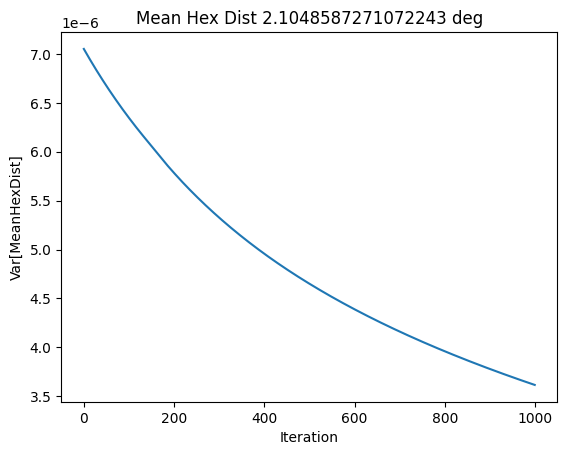

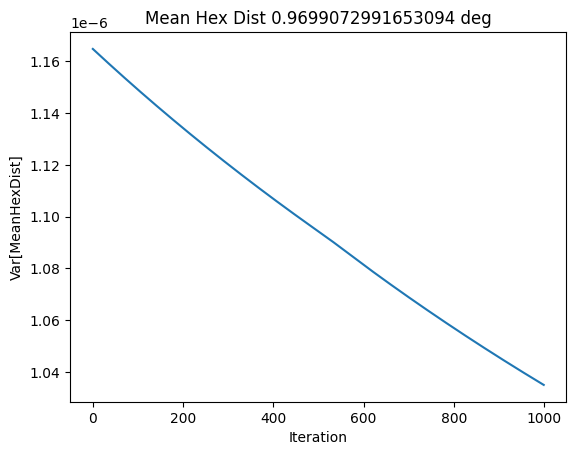

In [7]:
pointings = build_survey_moasic_pattern(num_pointings=int(1.33*8600), point_separation=None, lower_dec=-31 * au.deg,
                                        upper_dec=90 * au.deg)
eval_pointings = build_survey_moasic_pattern(num_pointings=int(1.33*40000), point_separation=None, lower_dec=-30 * au.deg,
                                             upper_dec=90 * au.deg)

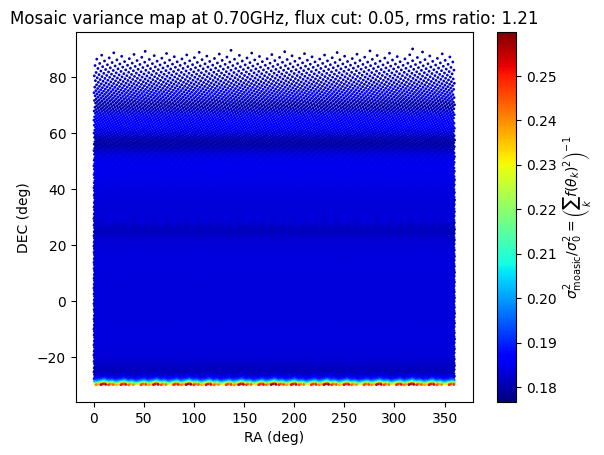

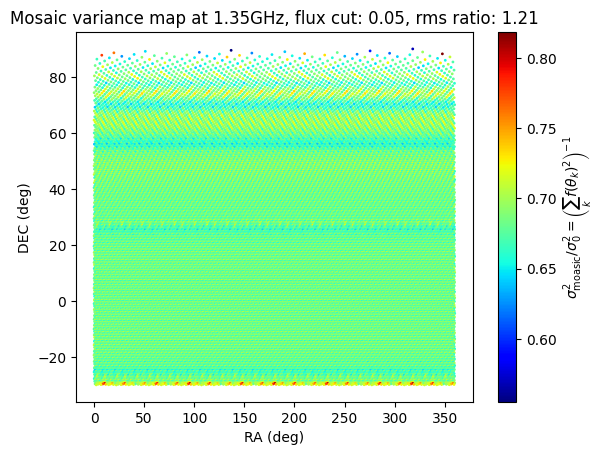

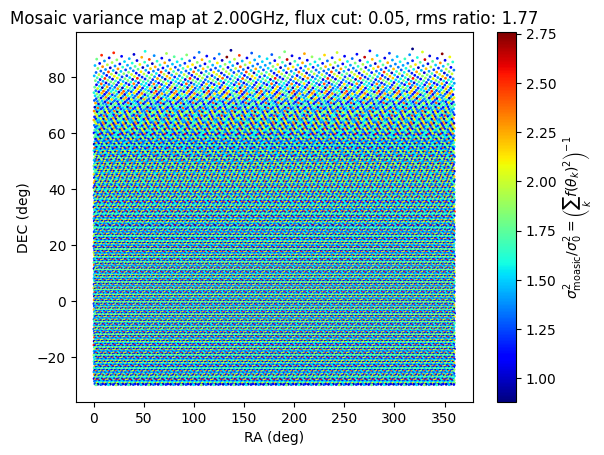

In [8]:
flux_cut = 0.05
for freq in [0.7, 1.35, 2]:

    eval_sensitivity = evaluate_global_sensitivity_pattern(pointings, eval_pointings, fov_fwhm=3.06 * au.deg * (1.35 / freq), k=100, flux_cut=flux_cut)
    ratio = np.sqrt(np.max(eval_sensitivity) / np.min(eval_sensitivity))
    plt.title(f"Mosaic variance map at {freq:.2f}GHz, flux cut: {flux_cut}, rms ratio: {ratio:.2f}")
    plt.savefig(f"sensitivity_map_{int(freq*1000)}MHz_cut{flux_cut:.2f}.png", dpi=300)
    plt.show()



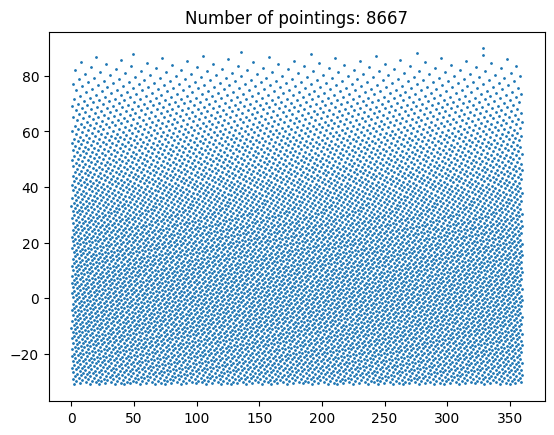

In [9]:
plt.scatter(pointings.ra, pointings.dec, s=1)
plt.title(f"Number of pointings: {len(pointings)}")
plt.show()

In [14]:
from dsa2000_cal.common.serialise_utils import SerialisableBaseModel
import astropy.units as au
import astropy.coordinates as ac

class SurveyPointingsV1(SerialisableBaseModel):
    pointings: ac.ICRS

survey_pointings = SurveyPointingsV1(pointings=pointings)

with open('survey_pointings_v1.json', 'w') as f:
    f.write(survey_pointings.json(indent=2))

survey_pointings = SurveyPointingsV1.parse_file('survey_pointings_v1.json')

print(survey_pointings.pointings)

<ICRS Coordinate: (ra, dec) in deg
    [(328.88708087,  89.85172121), (135.64056827,  88.75188608),
     (275.8150158 ,  88.32370549), ..., (127.25737576, -30.97488149),
     (264.76513561, -30.98653843), ( 42.27289489, -30.99819841)]>


In [ ]:
from dsa2000_cal.assets.registries import misc_registry

misc_registry.get_instance(misc_registry.get_match('survey_pointings_v1'))